# Wind rose data

Here we demonstrate how mean results over wind rose data are calculated in `foxes`. We need the following imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import foxes
import foxes.variables as FV

First, we initialize the engine:

In [2]:
engine = foxes.Engine.new("process", chunk_size_states=1000, chunk_size_points=3000)
engine.initialize()

Next, let's setup the wind farm. We choose 6 x 5 turbines on a regular grid:

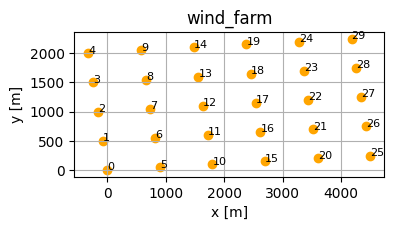

In [3]:
farm = foxes.WindFarm()
foxes.input.farm_layout.add_grid(
    farm=farm,
    xy_base=[0.0, 0.0],
    step_vectors=[[900.0, 50.0], [-80.0, 500.0]],
    steps=[6, 5],
    turbine_models=["NREL5MW", "kTI_05"],
    verbosity=0,
)

ax = foxes.output.FarmLayoutOutput(farm).get_figure(figsize=(4, 3))
plt.show()

Next, we create the states based on the static data file `wind_rose_bremen.csv.gz`. The data represents a (coarse) wind rose with 216 states. Each of them consists of the wind direction and wind speed bin centres, and the respective statistical weight of the bin (normalized such that 1 represents 100%):
```
state,wd,ws,weight
0,0.0,3.5,0.00158
1,0.0,6.0,0.00244
2,0.0,8.5,0.00319
3,0.0,12.5,0.0036700002
4,0.0,17.5,0.00042
...
```
Let's create the states object and have a look at the wind rose:

ProcessEngine: Calculating 216 states for 1 turbines


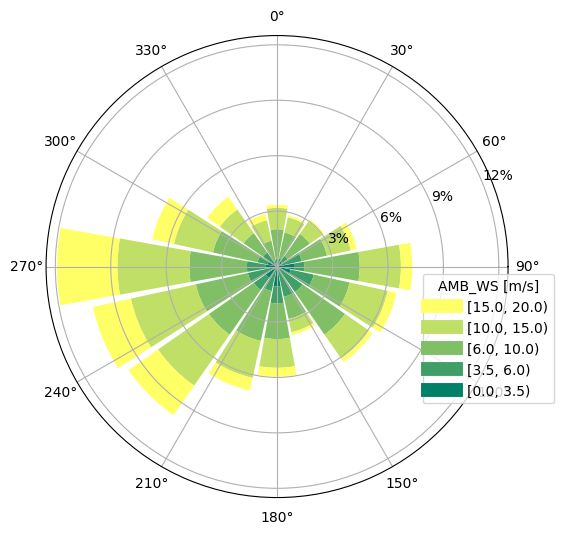

In [4]:
states = foxes.input.states.StatesTable(
    data_source="wind_rose_bremen.csv",
    output_vars=[FV.WS, FV.WD, FV.TI, FV.RHO],
    var2col={FV.WS: "ws", FV.WD: "wd", FV.WEIGHT: "weight"},
    fixed_vars={FV.RHO: 1.225, FV.TI: 0.05},
)

o = foxes.output.StatesRosePlotOutput(states, point=[0.0, 0.0, 100.0])
o.get_figure(16, FV.AMB_WS, [0, 3.5, 6, 10, 15, 20], figsize=(6, 6))
plt.show()

We can now setup our algorithm. In this example, we invoke one wake model for the wind deficit, `Bastankhah_linear` (with linear wake superposition), and another for the turbulence intensity wake effect, `CrespoHernandez_max` (with maximum wake superposition). Both obtain the wake growth parameter `k` by a relation `k = 0.5 * TI`, see `turbine_models` choice in the wind farm setup. We use default partial wakes for both models, indicated py `partial_wakes=None`:

In [5]:
algo = foxes.algorithms.Downwind(
    farm,
    states,
    rotor_model="centre",
    wake_models=["Bastankhah2014_linear", "CrespoHernandez_max"],
    partial_wakes=None,
    verbosity=0,
)

We can now calculate the results:

ProcessEngine: Calculating 216 states for 30 turbines
Efficiency added to farm results


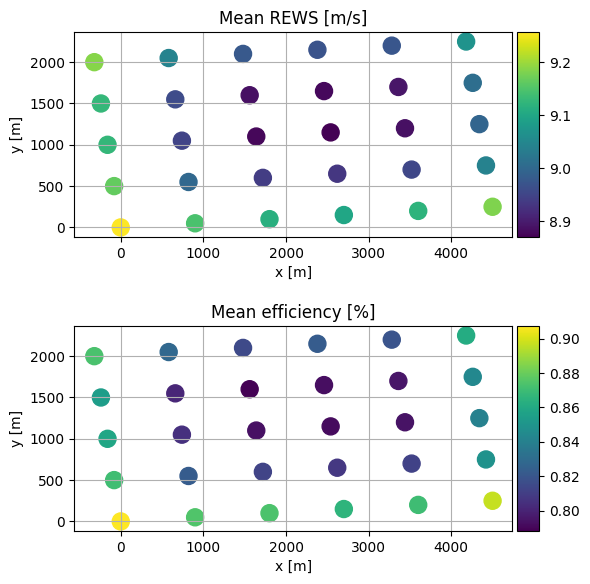


Farm power        : 76.5 MW
Farm ambient power: 81.7 MW
Farm efficiency   : 93.65 %
Annual farm yield : 670.45 GWh


In [6]:
farm_results = algo.calc_farm()

o = foxes.output.FarmResultsEval(farm_results)
o.add_efficiency()

fig, axs = plt.subplots(2, 1, figsize=(6, 7))
o = foxes.output.FarmLayoutOutput(farm, farm_results)
o.get_figure(
    fig=fig,
    ax=axs[0],
    color_by="mean_REWS",
    title="Mean REWS [m/s]",
    s=150,
    annotate=0,
)
o.get_figure(
    fig=fig,
    ax=axs[1],
    color_by="mean_EFF",
    title="Mean efficiency [%]",
    s=150,
    annotate=0,
)
plt.show()

o = foxes.output.FarmResultsEval(farm_results)
P0 = o.calc_mean_farm_power(ambient=True)
P = o.calc_mean_farm_power()
print(f"\nFarm power        : {P / 1000:.1f} MW")
print(f"Farm ambient power: {P0 / 1000:.1f} MW")
print(f"Farm efficiency   : {o.calc_farm_efficiency() * 100:.2f} %")
print(f"Annual farm yield : {o.calc_farm_yield(algo=algo):.2f} GWh")

Finally, we display the mean wind speed field as a 2D plot, including wake effects:

States 'StatesTable': Reading file /home/jonas/gits/wakes/foxes/foxes/data/states/wind_rose_bremen.csv
ProcessEngine: Calculating data at 21255 points for 216 states


ProcessEngine: Computing 8 chunks using 16 processes


  0%|                                                                                                    | 0/8 [00:00<?, ?it/s]

 12%|███████████▌                                                                                | 1/8 [00:08<00:59,  8.49s/it]

 25%|███████████████████████                                                                     | 2/8 [00:08<00:21,  3.58s/it]

 38%|██████████████████████████████████▌                                                         | 3/8 [00:08<00:10,  2.07s/it]

 62%|█████████████████████████████████████████████████████████▌                                  | 5/8 [00:09<00:02,  1.07it/s]

 75%|█████████████████████████████████████████████████████████████████████                       | 6/8 [00:09<00:01,  1.40it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.16s/it]

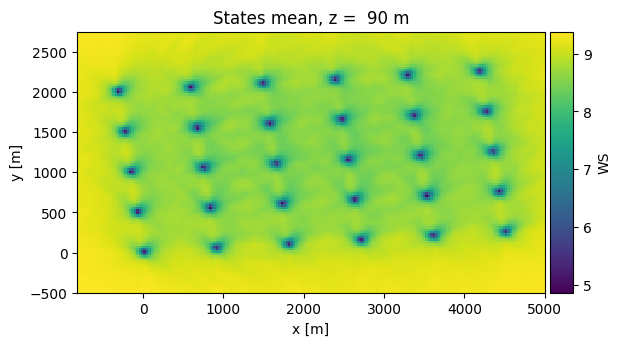

In [7]:
o = foxes.output.FlowPlots2D(algo, farm_results)
o.get_mean_fig_xy(FV.WS, resolution=30)
plt.show()

After all work is down, let's shutdown the engine:

In [8]:
engine.finalize()